# 1. Regression Methods

In [ ]:
# Import all libraries

# Import libraries
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import copy
from IPython.display import clear_output

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
from pandas.plotting import table 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.1. Processing stock price data in Python

### 1.1.1 Natural-Log Transform

First, we store the data in a pandas data frame setting a `datetime` index and dropping the `NaN` values. We then perform the natural-log transform of the price. 

In [ ]:
# Read price data
date_format = lambda x: datetime.strptime(x, "%d/%m/%Y")
px = pd.read_csv("priceData.csv", index_col='date', parse_dates=True, date_parser=date_format)
px.dropna(inplace=True)

logpx = np.log(px)

We then plot both the data for the SPX Index (between 1930 and 2017) and its natural-log transform in the figure below. Log transformation is a useful tool to stabilise the variance of time series. It is also used to compress the range of the data, making it see relevant trends and hence making the data easier to process. 

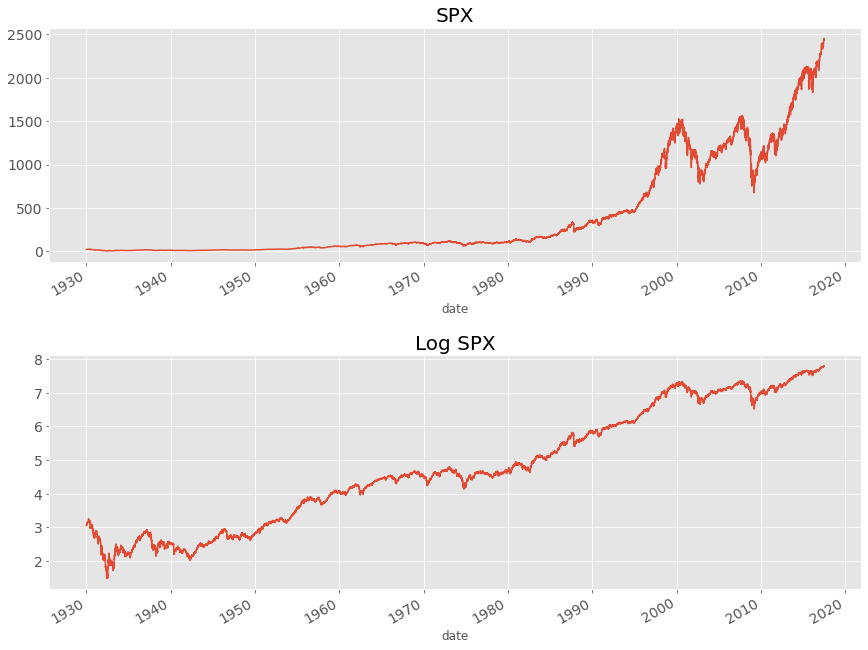

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(12,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

px.plot(ax=axes[0], fontsize=14, legend=None); axes[0].set_title("SPX", fontsize=20)
logpx.plot(ax=axes[1], fontsize=14, legend=None); axes[1].set_title("Log SPX", fontsize=20)

fig.savefig('SPX_and_LogSPX.eps', dpi=200, bbox_inches='tight')

### 1.1.2 Stationarity

A stochastic signal is referred to be wide-sense stationary (WSS), if the mean of the signal is time invariant and its autocorrelation function only depends on the time difference.

$$ x(t) = x(t+T)$$
$$ R_{xx}(t_1,t_2) = R_{xx}(t_2 - t_1)$$

Wide-sense stationarity for a signal means that the average of the signal stays the same over time and its autocorrelation only depends on the time difference. These concepts are the fundamentals behind the investment strategy based on the mean-reverting behaviour of a signal. Assuming there are 252 trading days in a year, we use a sliding window of 252 days to compute the first and second-order evolution statistics (mean and standard deviation) of the price and log-price time series. We use the sliding mean to represent the moving average of the price data which smoothen the signal. The sliding standard variation gives an idea about the volatility of the signal over the past trading year. From Figure 2, we observe that the moving average of price and log-price aren't stationary but instead upward trending. In particular, the log-price time series seem to be increasing at the constant rate over the past 70 years. 
We also observe the effect of the log transformation in stabilizing the variance. In the bottom right, we observe that the 252-day rolling standard deviation of the log-price data is more stationary, oscillating between 0 and 0.15 while the standard deviation of the price data is more volatile.

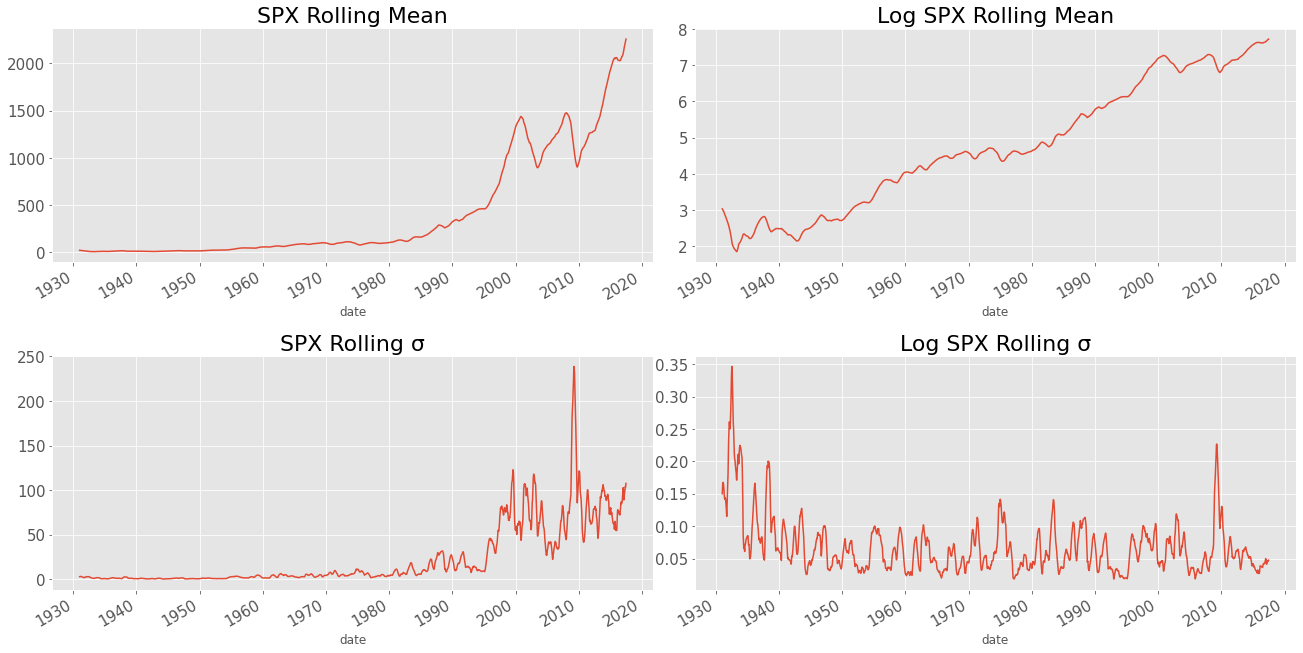

In [ ]:
window = 252

fig, axes = plt.subplots(2,2, figsize=(18,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Plot rolling statistics of price
px.rolling(window).mean().plot(ax=axes[0,0], fontsize=15, legend=None); axes[0,0].set_title("SPX Rolling Mean", fontsize=22)
px.rolling(window).std().plot(ax=axes[1,0], fontsize=15, legend=None); axes[1,0].set_title("SPX Rolling \u03C3", fontsize=22)

# Plot rolling statistics of log price
logpx.rolling(window).mean().plot(ax=axes[0,1], fontsize=15, legend=None); axes[0,1].set_title("Log SPX Rolling Mean", fontsize=22)
logpx.rolling(window).std().plot(ax=axes[1,1], fontsize=15, legend=None); axes[1,1].set_title("Log SPX Rolling \u03C3", fontsize=22)

fig.savefig('Rolling_Means_And_Stds.eps', dpi=200, bbox_inches='tight')

In [ ]:
# Average value of Log SPX rolling std
print(logpx.rolling(window).std().mean())

SPX Index    0.067923
dtype: float64


### 1.1.3 Simple and Log Returns

We have seen in part 1.1.2 that the time series for price and log-price was not stationary. However, it is often preferable to deal with stationary signals in financial analysis. Therefore, we look into return characteristics of the signal, which are better in terms of stationarity. The simple return, , is defined as the percentage increase of the price at each time step. 
$$ R_t = \frac{p_t - p_{t-1}}{r_{t-1}}$$
while the log return,  is defined as the difference between the successive log values of the price. 
$$ r_t = ln\left(\frac{p_t}{p_{t-1}}\right) $$
We have in the figure below the plots of the statistics for the simple and log return time series. At first sight, the plots for simple and log returns individual statistics look very similar. Although there are slight discrepancies, the time series of the simple and log returns are almost identical. This indicated the approximate simple-log equality which suggest that simple and log returns are equal for small returns $R_t 	\approx r_t$.

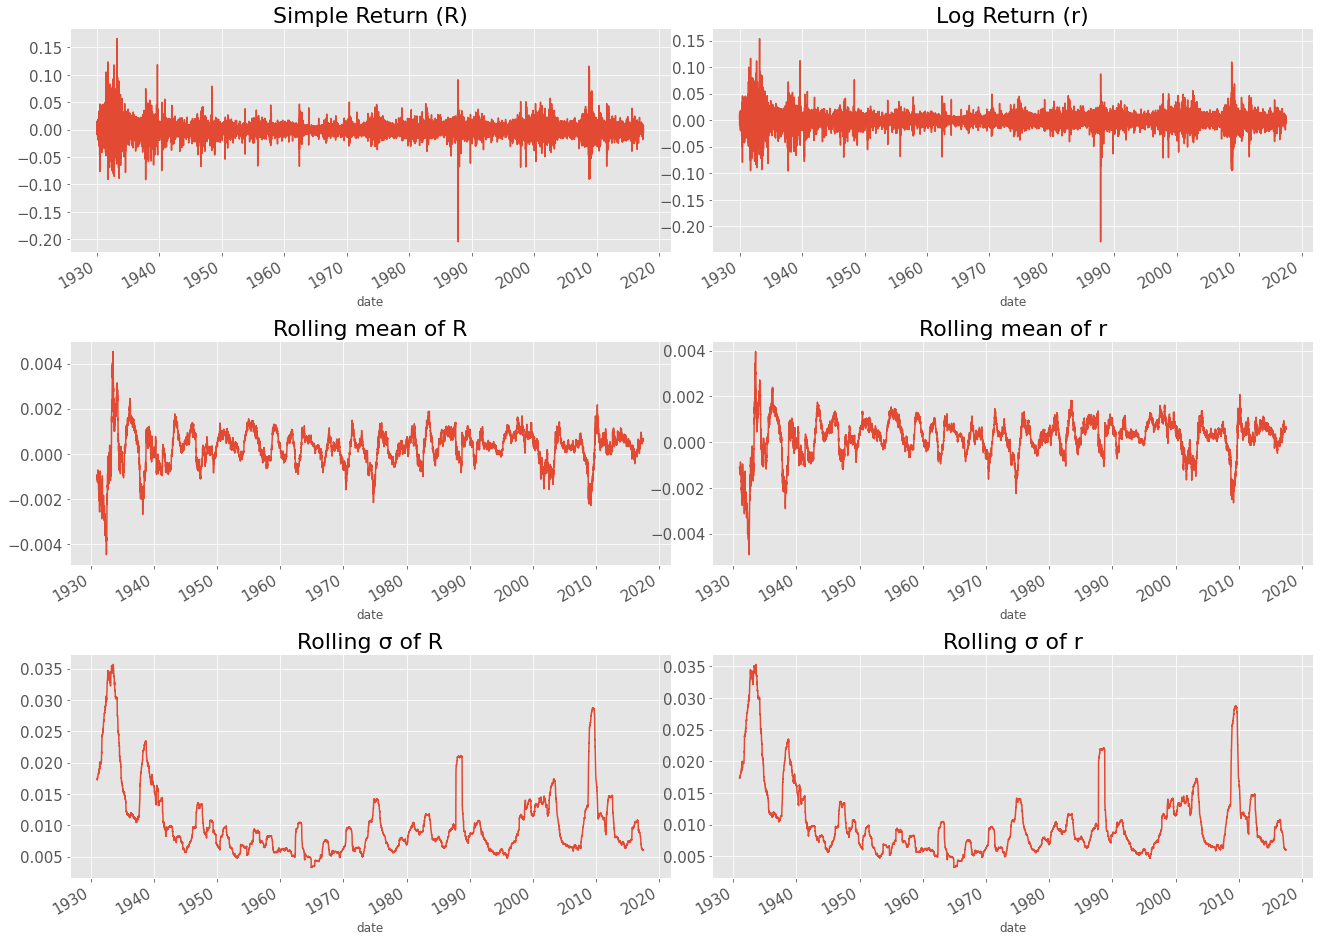

In [ ]:
simpret = px.pct_change()
logret = logpx.diff() 

fig, axes = plt.subplots(3,2, figsize=(18,15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Plot simple return time series and its rolling statistics
simpret.plot(ax=axes[0,0], fontsize=15, legend=None); axes[0,0].set_title("Simple Return (R)", fontsize=22)
simpret.rolling(window).mean().plot(ax=axes[1,0], fontsize=15, legend=None); axes[1,0].set_title("Rolling mean of R", fontsize=22)
simpret.rolling(window).std().plot(ax=axes[2,0], fontsize=15, legend=None); axes[2,0].set_title("Rolling \u03C3 of R", fontsize=22)

# Plot log return time series and its rolling statistics
logret.plot(ax=axes[0,1], fontsize=15, legend=None); axes[0,1].set_title("Log Return (r)", fontsize=22)
logret.rolling(window).mean().plot(ax=axes[1,1], fontsize=15, legend=None); axes[1,1].set_title("Rolling mean of r", fontsize=22)
logret.rolling(window).std().plot(ax=axes[2,1], fontsize=15, legend=None); axes[2,1].set_title("Rolling \u03C3 of r", fontsize=22)


fig.savefig('Simple_and_Log_Returns.eps', dpi=200, bbox_inches='tight')

### 1.1.4 Log returns over simple returns

As discussed in the previous sections, log transformations is suitable for time series due to its monotonicity and the fact that it compresses the range of the data which allows to see trends more clearly. In section 1.1.3, we also discussed that for small returns simple and log returns are approximately equal. In this section, we will continue the argument on why log-returns are more convenient to analyse than simple returns.
In quantitative finance, we often expect the prices to be log-normally distributed over short periods of time, (for longer periods, the distribution is more skewed since the market is generally upward trending). Since prices are considered normally distributed over short periods of time,we can assume log returns to be normally distributed. Because many signal processing techniques assume normal distribution, we often prefer using log returns for analysis. See the histogram plots in Figure 4 to visualise the distribution of the returns.
Another reason why we might prefer using logarithmic returns is that they provide time additivity, which is convenient when calculating compounded returns. That is, if we have 1\% return one day and -1\% return the next day, we end up with the same value; this is not the case with simple returns.
Due to their Gaussian distribution, log returns are symmetric as seen in Figure 4. Furthermore, the sum of Gaussian variables is also Gaussian which makes it convenient for signal processing operations.
We also note the fact that logarithms and exponents allow easier manipulation with calculus. Logarithms also offer numerical stability, meaning adding small numbers don't have significant effects (however, multiplying with small numbers can have large effects).

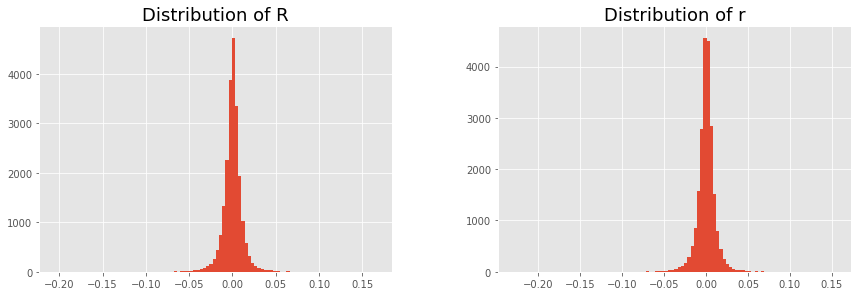

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()

simpret.hist(ax=axes[0], bins=100); axes[0].set_title("Distribution of R", fontsize=18)
logret.hist (ax=axes[1], bins=100); axes[1].set_title("Distribution of r", fontsize=18)

fig.savefig('Simple_and_Log_Returns_Distribution.eps', dpi=200, bbox_inches='tight')

There are multiple tests available that make it is possible to test a signal's Gaussianity. One of them is the "Jarque-Bera" test, which checks whether the sample data has the skewness and kurtosis matching a normal distribution and is available under scipy.stats module in Python. A normal distribution has skewness equal to 0 and kurtosis equal to 3. Therefore, the closer the JB statistic is to 0, the closer the distribution of the sample is to a Gaussian.

In [ ]:
# Since the value at the first index is NaN for both returns, we start with the second index
simp_JB = [stats.jarque_bera(simpret[1:i]) for i in range(100, len(simpret)-1, 100)]
log_JB  = [stats.jarque_bera( logret[1:i]) for i in range(100, len(logret )-1, 100)]

simp_JB_stat = [x[0] for x in simp_JB]
simp_JB_p    = [x[1] for x in simp_JB]

log_JB_stat = [x[0] for x in log_JB]
log_JB_p    = [x[1] for x in log_JB]

x = [i for i in range(100, len(simpret)-1, 100)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


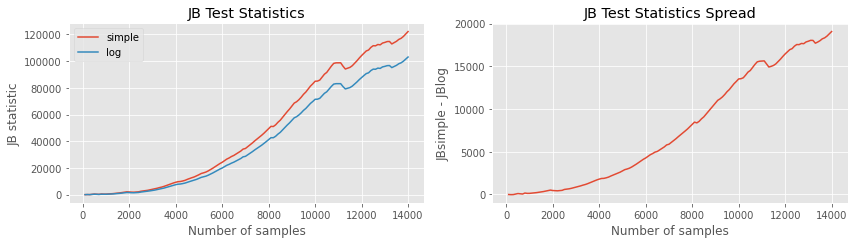

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,3.5))

axes[0].plot(x[:140], np.array(simp_JB_stat[:140]), label="simple")
axes[0].plot(x[:140], np.array( log_JB_stat[:140]), label="log")
axes[0].set_title('JB Test Statistics')
axes[0].set_xlabel('Number of samples'); axes[0].set_ylabel('JB statistic')
axes[0].legend()

axes[1].plot(x[:140], np.array(simp_JB_stat[:140]) - np.array(log_JB_stat[:140]) )
axes[1].set_title('JB Test Statistics Spread')
axes[1].set_xlabel('Number of samples'); axes[1].set_ylabel('JBsimple - JBlog')

fig.tight_layout()

fig.savefig('JB_Test.eps', dpi=200, bbox_inches='tight')

In [ ]:
JB_simp, p_simp = stats.jarque_bera(simpret[1:67])
JB_log , p_log  = stats.jarque_bera(logret[1:67])
print('Short-term: JB statistic for simple returns, p-value = ', JB_simp, ',', p_simp)
print('Short-term: JB statistic for log returns, p-value    = ', JB_log , ',', p_log )

Short-term: JB statistic for simple returns, p-value =  1.7477977070487296 , 0.4173212986426027
Short-term: JB statistic for log returns, p-value    =  1.8215734726963881 , 0.40220766813490383


In [ ]:
JB_simp, p_simp = stats.jarque_bera(simpret[1:253])
JB_log , p_log  = stats.jarque_bera(logret[1:253])
print('Longer-term: JB statistic for simple returns, p-value = ', JB_simp, ',', p_simp)
print('Longer-term: JB statistic for log returns, p-value    = ', JB_log , ',', p_log )

Longer-term: JB statistic for simple returns, p-value =  25.87351370187126 , 2.4078968906549036e-06
Longer-term: JB statistic for log returns, p-value    =  33.82712145856474 , 4.5137126258865123e-08


In [ ]:
JB_simp, p_simp = stats.jarque_bera(simpret[1:500])
JB_log , p_log  = stats.jarque_bera(logret[1:500])
print('Longer-term: JB statistic for simple returns, p-value = ', JB_simp, ',', p_simp)
print('Longer-term: JB statistic for log returns, p-value    = ', JB_log , ',', p_log )

Longer-term: JB statistic for simple returns, p-value =  449.3741655150386 , 0.0
Longer-term: JB statistic for log returns, p-value    =  339.1267534754359 , 0.0


We plot the JB statistic of simple and log returns for different number of samples on the left side in the figure above, observing that the values increase with increasing number of samples. The statistic for simple returns increases faster than that of log returns, and we plot this spread on the right side. This indicates the fact that log returns exhibit more Gaussianity than do the simple returns. In addition, both returns exhibit Gaussianity for the short-term (e.g. p-values for the JB Test of quarterly data are over 0.4), but that is not the case for the long-term.

### 1.1.5 Simple and log return example

If I purchase a stock at £1 and its value goes up to £2, the simple return would be 100% and the log return would be 69%. The following day the stock goes back to £1, my daily simple return is now -50% and my log return for the day is -69%. We observe that the sum of the logarithmic returns is zero when the value of the stock stays constant, which implies the time additivity property of log returns. We can conclude, that arithmetic sum of log returns is more suitable than simple returns to describe the value gained by an asset over time as it provides computational advantages in the analysis of financial data.

### 1.1.6 When not to use log returns

We mentioned in section 1.1.4 that we assume the prices to be log-normally distributed over short periods of time. However, this assumption does not hold over long time scales: log-normal distributions are positively skewed, but often financial data are negatively skewed in long time scales due to financial crashes. Therefore, we should not use logarithmic returns when doing long-term analysis. Furthermore, when calculating the overall return of a portfolio, it is more convenient to use simple returns because they are linearly additive across assets, whereas logarithmic returns are not.

## 1.2. ARMA vs. ARIMA Models for Financial Applications

An autoregressive-moving-average model is a stochastic process composed of two part.

An AR part (autoregressive) that regresses the variable with its own lagged values. This component aims to explain the momentum and mean reversion effects often observed in trading markets.

An MA part (moving average)c which models error terms as a linear combination of error terms at various times in the past. This component tried to capture the shock effects observed as white noise. In the financial context, these can be thought of as unexpected events such as wars or major news that would cause sudden movements. 

ARMA models assume stationarity of the data. This means that when sources of non-stationarity are present, like a global trend, the ARMA model in its original form may not be particularly suitable for analysis.

### 1.2.1 Suitability of ARMA and ARIMA Models

In [ ]:
# Read S&P 500 data
mydateparser = lambda x: datetime.strptime(x, '%Y-%m-%d')
snp = pd.read_csv('snp_500_2015_2019.csv', index_col='Date', parse_dates=True, date_parser=mydateparser)
snp_close = snp['Close'].to_frame().apply(np.log)

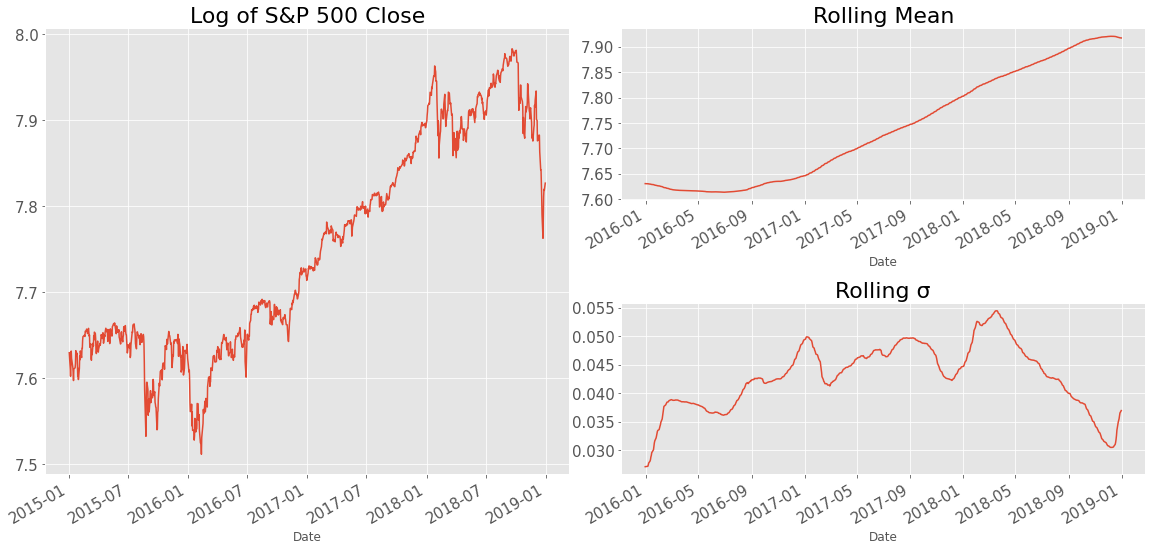

In [ ]:
window = 252

fig, axes = plt.subplots(2,2, figsize=(16,8))

axes[0,0].remove()
axes[1,0].remove()
ax_left = fig.add_subplot(2,2,(1,3))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.1)

snp_close.plot(ax=ax_left, fontsize=15, legend=None); ax_left.set_title("Log of S&P 500 Close", fontsize=22)
snp_close.rolling(window).mean().plot(ax=axes[0,1], fontsize=15, legend=None); axes[0,1].set_title("Rolling Mean", fontsize=22)
snp_close.rolling(window).std().plot(ax=axes[1,1], fontsize=15, legend=None); axes[1,1].set_title("Rolling \u03C3", fontsize=22)

fig.savefig('SP_Close_and_stats.eps', dpi=200, bbox_inches='tight')

In the figure above, we illustrate the historical close prices for the S&P500 together with its rolling mean and standard deviation. We can easily see that there is an upward trend in the prices, which suggest that the signal is not stationary. As mentioned before, ARMA models assume stationarity in the signal hence it would not be appropriate to use them to model the S&P500 close prices. Instead, we explore the use of ARIMA models which account for nonstationarity of signal by applying a differencing operation.

### 1.2.2 Fitting an ARMA model

For this section, an ARIMA(1,0,0) model is used to fit the S&P 500 data, meaning that it is a first order auto-regressive model. This model is suitable for the financial time series because it is often assumed to be a martingale process, where the conditional expectation of next value given all prior values is equal to the present value only.

In [ ]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']

# model summary
print(ARIMA(snp_arma['True'], order=(1,0,0)).fit().summary())

                              ARMA Model Results                              
Dep. Variable:                   True   No. Observations:                 1006
Model:                     ARMA(1, 0)   Log Likelihood                3352.702
Method:                       css-mle   S.D. of innovations              0.009
Date:                Mon, 21 Mar 2022   AIC                          -6699.405
Time:                        22:26:26   BIC                          -6684.664
Sample:                             0   HQIC                         -6693.804
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7400      0.078     99.461      0.000       7.587       7.893
ar.L1.True     0.9974      0.002    530.470      0.000       0.994       1.001
                                    Roots           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
snp_arma['Res'] = ARIMA(snp_arma['True'], order=(1,0,0)).fit().resid
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


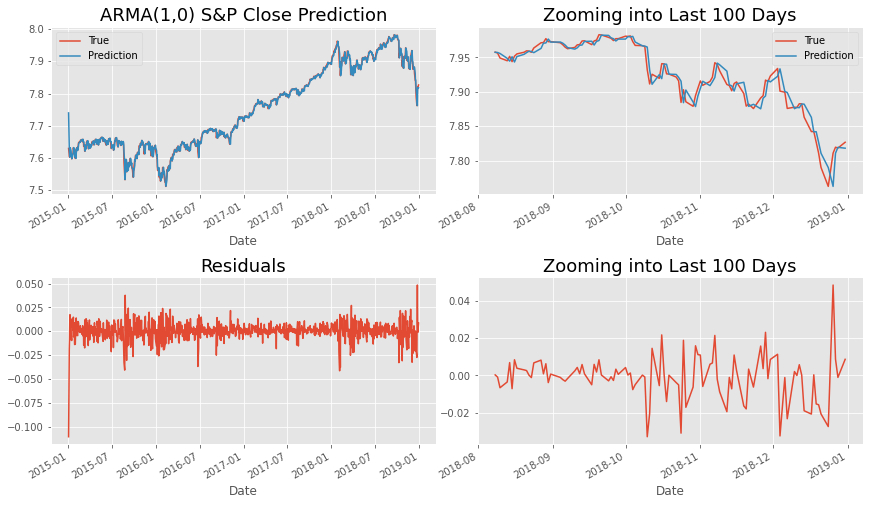

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,7.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

snp_arma[['True', 'Prediction']].plot(ax=axes[0,0]); axes[0,0].set_title("ARMA(1,0) S&P Close Prediction", fontsize=18)
snp_arma[['True', 'Prediction']][-100:].plot(ax=axes[0,1]); axes[0,1].set_title("Zooming into Last 100 Days", fontsize=18)

snp_arma['Res'].plot(ax=axes[1,0]); axes[1,0].set_title("Residuals", fontsize=18)
snp_arma['Res'][-100:].plot(ax=axes[1,1]); axes[1,1].set_title("Zooming into Last 100 Days", fontsize=18)

fig.savefig('ARMA_prediction.eps', dpi=200, bbox_inches='tight')

In [ ]:
ARMA_mae = abs(snp_arma['Res']).mean()
print('ARMA Mean Absolute Error: ', ARMA_mae)

ARMA Mean Absolute Error:  0.005974466656408824


The AR(1) model fits the function quite well, with the figure below showing the true vs predicted values and the residual of last 100 days, with an mean absolute residual of 0.005974. Overall, the prediction is a lagged version of the real signal. It is also interesting to see that the residuals are smaller for well-behaved part of the signal. This is also expected since the model does not have a moving average part that models the shocks of exogenous events which can cause higher volatility.

Furthermore, because the given AR(1) model assumes the signal to be purely martingale without accounting for the shock effects in the market, it diverges from the reality. The prediction can be basically viewed as a one time step lagged version of the true signal, which is not very useful in practice. Finally, this model does not account for the non-stationarity in the signal, and we will look into this in the next section.

### 1.2.3 Fitting an ARIMA model

In the previous section, we mentioned that ARMA models assume stationarity and are not suitable for non-stationary signals. In this section, we use an ARIMA(1,1,0) model which is really similar to the ARMA previously used with the exception that it applies an initial differencing on the time-series to remove elements of non-stationarity. As we had concluded that the S&P 500 close price data was showing an upward trend making the signal non-stationary, it is more appropriate to use an ARIMA model instead of an ARMA.

In [ ]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ['True']

# model summary
print(ARIMA(snp_arima['True'], order=(1,1,0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.True   No. Observations:                 1005
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3351.549
Method:                       css-mle   S.D. of innovations              0.009
Date:                Mon, 21 Mar 2022   AIC                          -6697.099
Time:                        22:26:28   BIC                          -6682.361
Sample:                             1   HQIC                         -6691.499
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.728      0.467      -0.000       0.001
ar.L1.D.True    -0.0088      0.032     -0.277      0.782      -0.071       0.053
                                    Roots   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
snp_arima['Res'] = ARIMA(snp_arima['True'], order=(1,1,0)).fit().resid
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


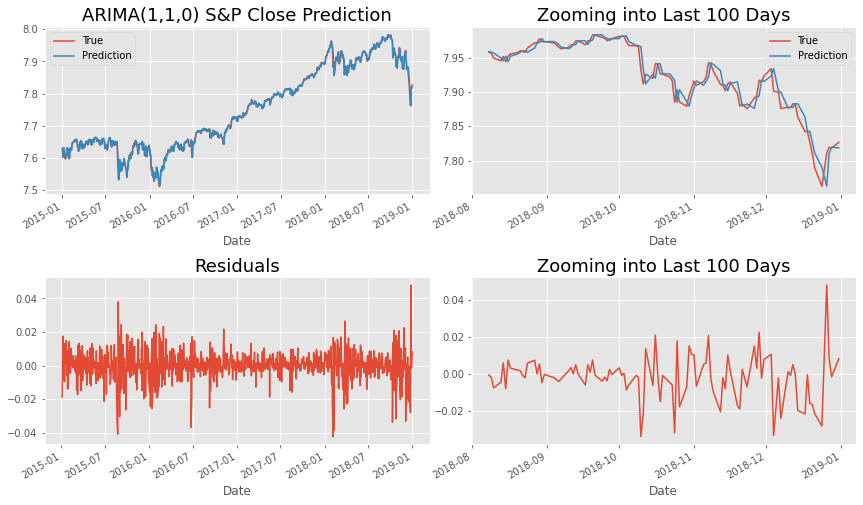

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,7.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)


snp_arima[['True', 'Prediction']].plot(ax=axes[0,0]); axes[0,0].set_title("ARIMA(1,1,0) S&P Close Prediction", fontsize=18)
snp_arima[['True', 'Prediction']][-100:].plot(ax=axes[0,1]); axes[0,1].set_title("Zooming into Last 100 Days", fontsize=18)

snp_arima['Res'].plot(ax=axes[1,0]); axes[1,0].set_title("Residuals", fontsize=18)
snp_arima['Res'][-100:].plot(ax=axes[1,1]); axes[1,1].set_title("Zooming into Last 100 Days", fontsize=18)


fig.savefig('ARIMA_prediction.eps', dpi=200, bbox_inches='tight')

In [ ]:
ARIMA_mae = abs(snp_arima['Res']).mean()
print('ARIMA Mean Absolute Error: ', ARIMA_mae)

ARIMA Mean Absolute Error:  0.005847927121955936


In [ ]:
error_improvement = (ARIMA_mae - ARMA_mae)/ ARMA_mae
print("The error from ARMA has decreased by %.2f%%."%(error_improvement * -100))

The error from ARMA has decreased by 2.12%.


The plots are very similar to those of the AR(1) model in section 1.2.2, though we observe a slight improvement of 2% in the mean absolute error. The AR coefficient, -0.0088, is very close to zero, indicating there is little correlation between successive returns and that the model is not very suitable for practical purposes. Furthermore, similar to AR(1), this model also doesn't account for shock effects due to the lack of an MA part.

This ARIMA model, with an integrating order of 1, takes the difference between successive log-prices and applies an ARMA to these differences. Because these values represent log-returns, they are normally distributed and are stationary, as we discussed in previous sections. Because applying an ARMA model to a stationary signal is more appropriate, this analysis is more meaningful.

### 1.2.4  Necessity of taking the log for ARIMA

An ARIMA model applies a one time time series difference to an ARMA model and it uses log-return data to perform log-price prediction. Because of the time additivity property of log returns, the ARIMA model is fitting an auto regressive model on successive log returns. In addition, the log-return data is a stationary signal which makes it suitable to use on an ARMA model and improves the quality of modelling. 

## 1.3. Vector Autoregressive (VAR) Models

The vector auto-regressive (VAR) model is an extension of the AR model where the predicted values are dependent on the past values of multiple variables. It is used to model variables that exhibit correlation with their own past values as well as past values from other variables. A VAR(*p*) process is given by:
$$\mathbf{y}_{t} = \mathbf{c}+\mathbf{A}_{1}\mathbf{y}_{t-1}+\mathbf{A}_2\mathbf{y}_{t-2}+...+\mathbf{A}_p\mathbf{y}_{t-p}+\mathbf{e}_t\tag{1}$$

or, in expanded matrix notation:
$$ \begin{bmatrix} y_{1,t} \\ y_{2,t} \\ \vdots \\ y_{k,t} \end{bmatrix} =
\begin{bmatrix} c_{1} \\ c_{2} \\ \vdots \\ c_{k} \end{bmatrix} +
\begin{bmatrix} a^1_{1,1} & a^1_{1,2} & \cdots & a^1_{1,k} \\
a^1_{2,1} & a^1_{2,2} & \cdots & a^1_{2,k} \\
\vdots & \vdots & \ddots & \vdots \\
a^1_{k,1} & a^1_{k,2} & \cdots & a^1_{k,k}
\end{bmatrix}
\begin{bmatrix} y_{1,t-1} \\ y_{2,t-1} \\ \vdots \\ y_{k,t-1} \end{bmatrix}
+ \cdots + 
\begin{bmatrix} a^p_{1,1} & a^p_{1,2} & \cdots & a^p_{1,k} \\
a^p_{2,1} & a^p_{2,2} & \cdots & a^p_{2,k} \\
\vdots & \vdots & \ddots & \vdots \\
a^p_{k,1} & a^p_{k,2} & \cdots & a^p_{k,k}
\end{bmatrix}
\begin{bmatrix} y_{1,t-p} \\ y_{2,t-p} \\ \vdots \\ y_{k,t-p} \end{bmatrix}
+ \begin{bmatrix} e_{1,t} \\ e_{2,t} \\ \vdots \\ e_{k,t} \end{bmatrix}
\tag{2}
$$

### 1.3.1 Concise VAR matrix form

Now, taking the bases view of the matrix, we can rewrite the VAR model concisely with the following equation
$$\mathbf{Y} = \mathbf{B}\mathbf{Z}+ U \tag{3}$$
where: 

$$\mathbf{B}=\begin{bmatrix} \mathbf{c} & \mathbf{A}_1 & \mathbf{A}_2 & \cdots & \mathbf{A}_p \end{bmatrix}$$

$$\mathbf{Z}=\begin{bmatrix} 1 \\ \mathbf{y}^T_{t-1} \\ \mathbf{y}^T_{t-2} \\ \vdots \\ \mathbf{y}^T_{t-p} \end{bmatrix} $$

$$ \mathbf{U}=\mathbf{e}_t $$ 

$$ \mathbf{Y}=\mathbf{y}_t $$

However, we can generalise even further by extending the equation (3) of the VAR model to the mutli-period case, where ***T*** time-steps are modelled. In this case, we have:

$$\mathbf{Y}=\begin{bmatrix} \mathbf{y}_{t} & \mathbf{y}_{t+1} & \mathbf{y}_{t+2} & \cdots & \mathbf{y}_{t+T} \end{bmatrix}$$

$$
\mathbf{Z}=\begin{bmatrix} 1 & 1 & \cdots & 1 \\ 
\mathbf{y}_{t-1} & \mathbf{y}_{t} & \cdots & \mathbf{y}_{t-1+T} \\ 
\mathbf{y}_{t-2} & \mathbf{y}_{t-1} & \cdots & \mathbf{y}_{t-2+T} \\ 
\vdots & \vdots & \ddots & \vdots \\ 
\mathbf{y}_{t-p} & \mathbf{y}_{t-p+1} & \cdots & \mathbf{y}_{t-p+T}
\end{bmatrix} 
$$

$$\mathbf{U}=\begin{bmatrix} \mathbf{e}_{t} & \mathbf{e}_{t+1} & \mathbf{e}_{t+2} & \cdots & \mathbf{e}_{t+T} \end{bmatrix}$$

### 1.3.2 Optimal VAR coefficients

In order to find the optimal set of coefficients $\mathbf{B_{opt}}$, we aim to minimise $\mathbf{U = Y -BZ}$, which represents the error of our VAR model. We use the least-squares method to find the optimal set of coefficients with the following objective function $\mathbf{J(B)}$:

$$ \mathbf{J(B) = UU^T = (Y-BZ)(Y-BZ)^T} \tag{4}$$
$$ \mathbf{J(B) = YY^T - BZY^T - YZ^TB^T + BZZ^TB^T} $$

Then, setting the derivate of the objective function to 0, we solve for $\mathbf{B_{opt}}$ that minimises the following equation:

$$  \mathbf{\dfrac{\partial J(B)}{\partial B} = 0 ⇒ 2BZZ^T - 2YZ^T = 0} $$
$$ \mathbf{BZZ^T = YZ^T} $$
$$ \mathbf{B_{opt} = YZ^T(ZZ^T)^{-1}} \tag{5}$$

### 1.3.3 Stability of VAR

Let's consider a VAR(1) process, ie:

$$\mathbf{y_{t} = Ay_{t-1} + e_{t}}$$
$$\mathbf{y_{t-1} = Ay_{t-2} + e_{t-1}}$$

Recursively, we can rewrite the equation $\mathbf{y_t}$ from the equations above as:

\begin{align}
\mathbf{y_{t}} &= \mathbf{Ay_{t-1} + e_{t}} \\
&= \mathbf{A(Ay_{t-2}+e_{t-1}) + e_{t}} \\
\vdots \\
\mathbf{y_t} &= \mathbf{A^py_{t-p}} + \sum_{i=0}^{p-1}(\mathbf{A^ie_{t-i}}) \tag{6}
\end{align}

Assuming matrix $\mathbf{A}$ is diagonalisable, that is assuming $\mathbf{A}$ has $\mathbf{k}$ independent eigenvectors with corresponding eigenvalues, we can write:

\begin{align}
\mathbf{A} &= \mathbf{V\Lambda V^{-1}} \\
\mathbf{A^2} &= \mathbf{V\Lambda V^{-1}V\Lambda V^{-1} = V\Lambda^2V^{-1}} \\
\mathbf{A^n} &= \mathbf{V\Lambda^n V^{-1}} \tag{7} \\
\end{align}

where $\mathbf{V}$ is a matrix composed of $\mathbf{k}$ independent eigenvectors and $\mathbf{𝚲}$ is a diagonal matrix with the corresponding eigenvalues on the diagonals. 

If we replace (7) into (6), we see that if one of the eigenvalue in the diagonal of $\mathbf{𝚲}$ is greater than 1, the value of $\mathbf{y_t}$ diverges to infinity. For this reason, we need all the eigenvalues in $\mathbf{𝚲}$, and by extension in $\mathbf{A}$, to be less than 1 in absolute value for the stability of the model.


### 1.3.4 VAR Portfolio Analysis I

In this sub-section, we will analyse the construction of a portfolio using VAR models. We will first observe the close price time-series of five stocks, with ticker symbols 'CAG' 'MAR' 'LIN' 'HCP' 'MAT', and detrend the corresponding signals using the 66 days moving average (66 corresponding to 3x22 i.e. one quarter) to obtain zero-mean stationary time-series. We start by plotting the close price time series and detrended time series in the figures below.

In [ ]:
# Read data
mydateparser = lambda x: datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('snp_allstocks_2015_2019.csv', index_col='Date', parse_dates=True, date_parser=mydateparser)
info = pd.read_csv('snp_info.csv', index_col=0) 

In [ ]:
# Select stocks to analyze 
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tickers]

# Detrend with moving average of 66 days (one quarter)
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


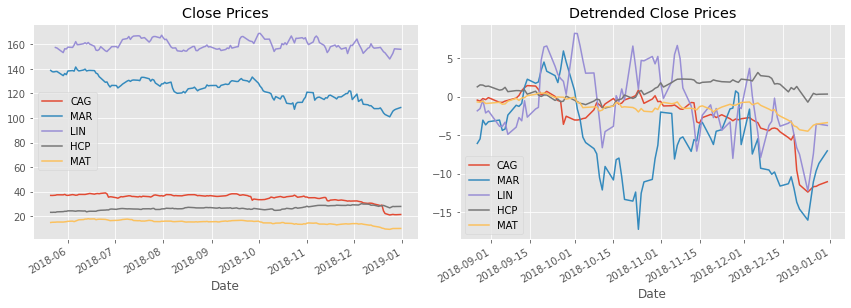

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()

stocks[-155:].plot(ax=axes[0]); axes[0].set_title("Close Prices")
stocks_detrended.plot(ax=axes[1]); axes[1].set_title("Detrended Close Prices")  

fig.savefig('Stock_prices_with_detrended.eps', dpi=200, bbox_inches='tight')

We then fit a VAR(1) model to the detrended time series and compute the eigenvalues of the regression matrix $\mathbf{A}$ as:

In [ ]:
model = VAR(stocks_detrended)
results = model.fit(1)
pd.DataFrame.to_latex(results.params[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &       CAG &       MAR &       LIN &       HCP &       MAT \\\\\n\\midrule\nL1.CAG &  0.872786 &  0.113179 & -0.281265 &  0.011912 &  0.058776 \\\\\nL1.MAR & -0.063745 &  0.895820 & -0.184820 & -0.005004 &  0.022917 \\\\\nL1.LIN &  0.000134 & -0.111678 &  0.704023 &  0.004982 & -0.025557 \\\\\nL1.HCP & -0.084776 & -0.083831 & -0.401417 &  0.931708 & -0.046406 \\\\\nL1.MAT &  0.643072 &  0.094931 &  2.033036 & -0.012884 &  0.802974 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)
print(eigA)

[0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]


We can observe that the diagonal of the above matrix contains the highest values, which is expected as this means that the time-series values are autocorrelated with their own past values. However, as these companies operate in different sectors (see table below), we see that the correlations of the assets between each other is very low and sometimes negative. This suggests that it is a good thing to build a portfolio containing these stocks, as having uncorrelated assets creates a diversified portfolio which lowers the risk.

In [ ]:
df = info.set_index('Symbol').T[tickers].loc['GICS Sector'].to_frame()
pd.DataFrame.to_latex(df)

'\\begin{tabular}{ll}\n\\toprule\n{} &             GICS Sector \\\\\nSymbol &                         \\\\\n\\midrule\nCAG    &        Consumer Staples \\\\\nMAR    &  Consumer Discretionary \\\\\nLIN    &               Materials \\\\\nHCP    &             Real Estate \\\\\nMAT    &  Consumer Discretionary \\\\\n\\bottomrule\n\\end{tabular}\n'

### 1.3.5 VAR Portfolio Analysis II

We reproduce the process applied in section 1.3.4, this time applying a VAR(1) model to entire sectors and we obtain the eigenvalues of the regression matrix $\mathbf{A}$ for each sector.

The overall expected return of a portfolio composed of $n$ assets is: $\overline{r_p} = \sum_{i=1}^n{w_i\overline{r_i}}$ and its variance is $\sigma^2= \sum_{i,j=1}^n{w_i\sigma_{ij}w_j}$ where $\overline{r_i}$ is the expected return for a particular asset $i$, $w_i$ is the weight assigned to that asset and $\sigma_{ij}$ is the covariance between two assets $i$ and $j$. For a given target return, investors aim to minimise the risk associated to it, represented by the variance of the portfolio. 

From the results below, we see that stocks from the same sectors are highly correlated between each other, which means the term $\sigma_{ij}$ is going to be high. Hence, in order to minimise risk it is advisable to construct a portfolio using assets from different sectors that are uncorrelated and will have a lower covariance.

In [ ]:
eigen_vals = {}

for sector in info['GICS Sector'].unique():
    
    # get stocks from the same sector
    tickers = info.loc[info['GICS Sector'] == sector]['Symbol'].tolist()
    stocks = df[tickers]
    
    # detrend signals
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()
    
    # fit VAR model
    model = VAR(stocks_detrended)
    results = model.fit(1)
    
    # get eigenvalues of the regression matrix A
    eigA, _ = np.linalg.eig(results.params[1:].values)
    eigen_vals[sector] = eigA 
    clear_output(wait=True)  

KeyError: ignored

In [ ]:
eig_vals_df = pd.DataFrame(index=eigen_vals.keys(), columns=['min eigenvalue', 'mean eigenvalue', 'max eigenvalue'], dtype=float)

for sector in eigen_vals:
    eig_vals = abs(eigen_vals[sector])
    eig_vals_df.loc[sector]['min eigenvalue'] = eig_vals.min()
    eig_vals_df.loc[sector]['mean eigenvalue'] = eig_vals.mean()    
    eig_vals_df.loc[sector]['max eigenvalue'] = eig_vals.max()   

pd.DataFrame.to_latex(eig_vals_df)